### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy.signal as sg
import subjects
from statannotations.Annotator import Annotator

### Plot ripples histogram for a single session

In [ ]:
from neuropy.plotting import plot_epochs
from scipy.stats import binned_statistic

sessions = subjects.sd.ratUday1

fig = Fig(grid=(2, 2))
for sub, sess in enumerate(sessions):
    ax = plt.subplot(fig.gs[sub])
    starts = sess.ripple.starts
    durations = sess.ripple.durations
    bins = np.arange(0, sess.eegfile.duration, 600)
    # hist_rpl = np.histogram(starts,bins=bins)[0]
    hist_rpl = binned_statistic(starts, durations, bins=bins, statistic="sum")[0]
    plot_epochs(ax, sess.paradigm)
    ax.plot(bins[:-1] + 300, hist_rpl / 600, "k")
    ax.set_xlabel("Time")
    ax.set_ylabel("Ripple rate")
    print(sess.ripple.metadata)

### Ripple rate first hour **between** SD and NSD (or only restrict to 1h NREM sleep of NSD)
- One possiblity of faster decay of replay during sleep deprivation could be reduced ripple rate at the begining of POST. This may suggest that in order for cells to replay they need sufficient number/amount of exicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.

In [ ]:
rpl_rate = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    w = 2 * 3600  # window size
    rpl_rate_sub = sess.ripple_nomerge.time_slice(post[0], post[0] + w).n_epochs / w
    rpl_rate.append(
        pd.DataFrame({"sub": sess.sub_name, "rpl_rate": [rpl_rate_sub], "grp": sess.tag})
    )

rpl_rate = pd.concat(rpl_rate, ignore_index=True)

In [ ]:
_, ax = plt.subplots()
import seaborn as sns

sns.lineplot(data=rpl_rate, x="grp", y="rpl_rate", hue="sub", marker="o")

### Ripple rate in 2.5 h blocks


In [5]:
sessions = subjects.ripple_sess()

ripple_rate_df, ripple_num_df = [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    epochs = sess.get_zt_epochs()
    rpls = sess.ripple.starts

    # --- only include rpls having PBE ------
    # rpl_epochs = sess.ripple.flatten()
    # pbe = sess.pbe.to_dataframe().peak_time.values
    # pbe_bool = np.histogram(pbe, rpl_epochs)[0][::2] > 0
    # rpls = rpls[pbe_bool]

    # binsz = np.diff(bins).mean()
    hist_rpl = np.histogram(rpls, bins=epochs.flatten())[0][::2]

    ripple_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_rpl / epochs.durations,
                "zt": epochs.labels,
                "session": sub,
                "name": sess.name,
                "grp": sess.tag,
            }
        ),
    )

    ripple_num_df.append(
            pd.DataFrame(
                {
                    "number": hist_rpl,
                    "zt": epochs.labels,
                    "session": sub,
                    "name": sess.name,
                    "grp": sess.tag,
                }
            ),
        )

ripple_rate_df = pd.concat(ripple_rate_df, ignore_index=True)
subjects.GroupData().save(ripple_rate_df, "ripple_rate")

ripple_num_df = pd.concat(ripple_num_df, ignore_index=True)
subjects.GroupData().save(ripple_num_df, "ripple_number")

ripple_rate saved
ripple_number saved


In [ ]:
import seaborn as sns
from neuropy.plotting import Fig
from statannotations.Annotator import Annotator

fig = Fig(grid=(7, 6))

ax = fig.subplot(fig.gs[0])
plot_kw = dict(
    data=ripple_rate_df,
    x="Zt",
    y="rate",
    hue="grp",
    hue_order=["NSD", "SD"],
    ax=ax,
    dodge=True,
)

sns.stripplot(
    **plot_kw, palette=subjects.colors_sd(1), edgecolor="k", linewidth=0.3, size=3
)
sns.boxplot(**plot_kw, color="k", width=0.5, **subjects.sns_boxplot_kw)
ax.tick_params("x", labelrotation=30)
ax.legend([], frameon=False)
ax.set_ylabel("Ripple_w_PBE rate")
ax.set_xlabel("")

# stats
# Across groups
orders = ripple_rate_df.Zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **subjects.stat_kw)
annotator.apply_and_annotate()
annotator.reset_configuration()

# Within groups
pairs2 = []
for g in ["NSD", "SD"]:
    pairs2.extend([((orders[_], g), (orders[_ + 1], g)) for _ in range(2)])
annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
annotator.configure(test="t-test_paired", **subjects.stat_kw)
annotator.apply_and_annotate()
annotator.reset_configuration()


fig.savefig(subjects.figpath_sd / "Ripple_w_PBE_rate")

### Ripple rate statewise in 2.5 h blocks


In [23]:
sessions = subjects.ripple_sess()

ripple_rate_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    epochs = sess.get_zt_epochs()
    rpls = sess.ripple.starts

    zt_epochs = sess.get_zt_epochs()
    wake_states = sess.brainstates.label_slice(["AW", "QW"])
    nrem_states = sess.brainstates.label_slice(["NREM"])

    for e in zt_epochs.itertuples():

        def get_rate(states: sess.brainstates):
            e_states = states.time_slice(e.start, e.stop, strict=False)
            if e_states.n_epochs > 0:
                rate = e_states.contains(rpls)[1].size / e_states.durations.sum()
            else:
                rate = np.nan
            return rate

        df = pd.DataFrame(
            dict(
                ripple_rate=[get_rate(wake_states), get_rate(nrem_states)],
                brainstate=["WK", "NREM"],
                zt=e.label,
                session=s,
                grp=sess.tag,
            )
        )

        ripple_rate_df.append(df)

ripple_rate_df = pd.concat(ripple_rate_df, ignore_index=True)
ripple_rate_df = ripple_rate_df.dropna(axis=0, how="any").reset_index(drop=True)
subjects.GroupData().save(ripple_rate_df, "ripple_rate_statewise_blocks")

ripple_rate_statewise_blocks saved


### Increasing trend from early to late sleep deprivation ?
One of the reviewers asked given the ripple rate is signficantly higher in second block of sleep deprivation, is it possible that if we bin it in a finer time window we will observe a significant increasing trend. 

In [17]:
sessions = subjects.ripple_sess()

bin_size = 300
ripple_rate_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    sd_period = [post[0], post[0] + 5 * 3600]
    n_bins = (5 * 3600) // 300
    # t_norm = np.linspace(0, 1, n_bins + 1)
    sd_bins = np.linspace(0, 5 * 3600, n_bins + 1) + post[0]
    rpls = sess.ripple.starts

    rpl_count = np.histogram(rpls, sd_bins)[0]

    df = pd.DataFrame(
        {
            "zt": np.round((sd_bins[:-1] - post[0]) / 3600, 2),
            "ripple_rate": rpl_count / bin_size,
            "session": s,
            "grp": sess.tag,
        }
    )

    ripple_rate_df.append(df)

ripple_rate_df = pd.concat(ripple_rate_df, ignore_index=True)

subjects.GroupData().save(ripple_rate_df, "ripple_rate_post5h_trend")

ripple_rate_post5h_trend saved


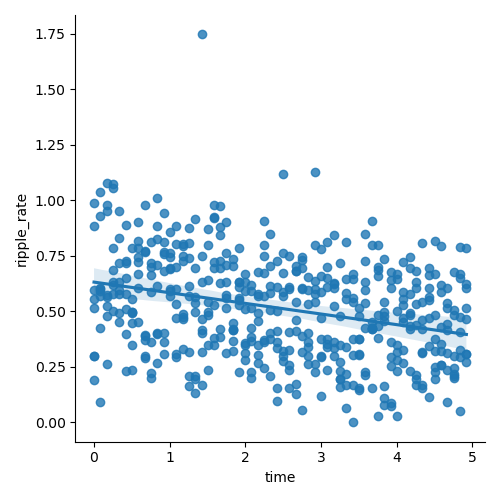

In [14]:
# _,ax = plt.subplots()

sns.lmplot(data=ripple_rate_df, x="zt", y="ripple_rate", units="session")

### Inter-ripple duration (Ripple ISI)


In [ ]:
sessions = subjects.ripple_sess()
dur_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.array([0, 4, 5])  # np.arange(0, 9, 4)
    t_starts = zts * 3600 + post[0]

    acg_zt = []
    firing_neurons = []
    for i, t in enumerate(t_starts):
        starts = sess.ripple.time_slice(t, t + 3600).starts
        dur_df.append(
            pd.DataFrame(
                {"isi": np.diff(starts), "Zt": f"Zt{zts[i]+1}", "grp": sess.tag}
            ),
        )

dur_df = pd.concat(dur_df, ignore_index=True)

In [ ]:
fig = plotting.Fig(grid=(5, 4))
bins = [np.arange(2, 50, 0.1), np.arange(0.5, 50, 0.1)]
for i, g in enumerate(["SD", "NSD"]):
    df = dur_df[dur_df["grp"] == g]
    ax = plt.subplot(fig.gs[i])
    sns.histplot(
        data=df,
        x="isi",
        hue="Zt",
        ax=ax,
        stat="probability",
        bins=bins[i],
        element="poly",
        common_bins=True,
        common_norm=False,
        fill=False,
        legend=None,
        cumulative=True,
        palette="Set2",
    )
    ax.set_xscale("log")
    # ax.set_yscale('log')
    # ax.grid()

### Total/mean ripple duration from first hour to last hour SD

In [ ]:
print(f"#Sessions {len(sessions)}")
rpl_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    # period = np.arange(9) * 3600 + post[0]
    zts = np.array([0, 2.5, 5])
    period = zts * 3600 + post[0]

    for i, t in enumerate(period):
        rpl_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i]}-{zts[i]+2.5}",
                    "rpl_duration": [
                        sess.ripple.time_slice(t, t + 2.5 * 3600).durations.sum()
                    ],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

rpl_duration = pd.concat(rpl_duration, ignore_index=True)

subjects.GroupData().save(rpl_duration, "ripple_total_duration")

In [ ]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))

colors = [subjects.sd.color(1.5), subjects.nsd.color(1.5)]
n_subs = [8, 8]
for i, grp in enumerate(["SD", "NSD"]):
    data = rpl_duration[rpl_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="rpl_duration",
        hue="sub",
        marker="o",
        palette=[colors[i]] * n_subs[i],
        ax=ax,
        legend=None,
        ci=None,
    )
    ax.legend("")
    # ax.set_xlim([-1,4])
    # ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### Ripple duration comparison between SD and NSD animals
- I compared the ripple duration distribution for Zt1 and Zt5 between NSD and SD sessions. Ripple durations were pooled across sessions. The distribution curves looked different in Zt1 (seems to be driven by outliers) but exactly the same during Zt5.

In [ ]:
sessions = subjects.ripple_sess()
rpl_dur, long_rpl = [], []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.arange(0, 7.5, 2.5)
    t_starts = zts * 3600 + post[0]
    epochs = sess.get_zt_epochs()

    for ind, e in enumerate(epochs.itertuples()):
        ep_durations = sess.ripple.time_slice(e.start, e.stop).durations
        # ep_long_prob = np.count_nonzero(ep_durations > 0.1) / len(ep_durations)
        kw = dict(zt=e.label, session=sub, grp=sess.tag)
        df1 = pd.DataFrame(
            dict(
                durations=ep_durations,
                zt=e.label,
                session=s,
                name=sess.name,
                grp=sess.tag,
            )
        )
        # df2 = pd.DataFrame(
        #     dict(
        #         prob=ep_long_prob,
        #         zt=e.label,
        #         session=s,
        #         name=sess.name,
        #         grp=sess.tag,
        #     )
        # )

        # df2 = pd.DataFrame({'prob':[ep_long_prob],**kw})
        rpl_dur.append(df1)
        # long_rpl.append(df2)

rpl_dur = pd.concat(rpl_dur, ignore_index=True)
# long_rpl= pd.concat(long_rpl, ignore_index=True)

In [ ]:
from plotters import violinplot

fig = plotting.Fig(grid=(7, 6))

y = ["durations", "prob"]
for i, data in enumerate([rpl_dur]):
    ax = fig.subplot(fig.gs[i])
    plot_kw = dict(
        data=data,
        x="zt",
        y=y[i],
        hue="grp",
        hue_order=["NSD", "SD"],
        # width=0.5,
        ax=ax,
    )
    violinplot(**plot_kw)
    ax.set_ylim(top=0.3)

    if i == 1:
        sns.stripplot(**plot_kw, dodge=True, color="k", s=3)
    ax.legend("", frameon=False)
    ax.tick_params("x", rotation=30)
    # ax.set_yscale('log')

    orders = rpl_dur.zt.unique()
    pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
    annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    annotator.configure(test="t-test_welch", **subjects.stat_kw)
    annotator.apply_and_annotate()
    annotator.reset_configuration()


# bootstrap(pairs,**plot_kw)
fig.savefig(subjects.figpath_sd / "ripple_durations")

### Asychronous ripples

In [ ]:
from neuropy.utils.signal_process import filter_sig, hilbertfast
import scipy.signal as sg

sessions = subjects.sd.ratUday4
# sessions = subjects.nsd.ratUday2

for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    channels = [85, 168]

    hil_amp = []
    for chan in channels:
        lfp = sess.eegfile.get_signal(chan, *period)
        lfp_bp = filter_sig.bandpass(lfp, lf=125, hf=250)
        hil_amp.append(stats.zscore(np.abs(hilbertfast(lfp_bp.traces[0]))))

    xcorr = sg.correlate(hil_amp[0], hil_amp[1], mode="same")

In [ ]:
lfp1 = sess.eegfile.get_signal(85, *period).traces[0]
lfp2 = sess.eegfile.get_signal(168, *period).traces[0]

coher = sg.coherence(lfp1, lfp2, fs=1250, nperseg=1250, noverlap=625)

In [ ]:
_, ax = plt.subplots()

ax.plot(hil_amp[0])
ax.plot(hil_amp[1])
# ax.plot(coher[0],coher[1])
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
_, ax = plt.subplots()

ax.plot(xcorr)